# Afriat

In [1]:
import warnings
import os
import sys
import gc

In [2]:
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import tqdm
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
from tardis._utils.warnings import suppress_stdout, ignore_predetermined_warnings
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
num_ood = 1  # not functioning

In [5]:
def get_availables():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
    availables = list(df[df>100].index)
    return availables

In [6]:
def calculate_r2_raw(true_array, pred_array, batch_size):
    r2s = []
    start_ind = 0
    for end_ind in range(batch_size, len(true_array), batch_size):
        t = true_array[start_ind:end_ind]
        p = pred_array[start_ind:end_ind]
        r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
        r2s.append(r2)
        start_ind = end_ind
    return np.mean(r2s)

In [7]:
def shuffle_rows_with_rng(matrix, seed):
    shuffled_matrix = matrix.copy()    
    for i, row in enumerate(shuffled_matrix):
        rng = np.random.default_rng(i+seed)
        rng.shuffle(row)
    return shuffled_matrix

In [8]:
def get_r2_random(ood_seed, batch_size=32):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
        adata = ad.read_h5ad(adata_file_path)
        df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
        availables = list(df[df>100].index)
        def adata_ood_creator(adata, seed, size):
            rng = np.random.default_rng(seed=seed)
            # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
            # choices = [availables[i] for i in random_choices]
            choices = [availables[ood_seed]]
            choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
            return adata[~choices_bool, :].copy(), choices_bool, choices[0]
        
        adata, choices_bool, choice = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

        model_name = f"afriat_v2_4_1_ood_expression-seed-{ood_seed}_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

        kk = ["zone", "status_control", "time_cat"]
        ood_sample_specs = list(adata_ood.obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "baseline"})
        
        results.update({
            "train": calculate_r2_raw(np.array(adata.X)[vae.train_indices], shuffle_rows_with_rng(np.array(adata.X)[vae.train_indices], seed=ood_seed), batch_size=batch_size),
            "validation": calculate_r2_raw(np.array(adata.X)[vae.validation_indices], shuffle_rows_with_rng(np.array(adata.X)[vae.validation_indices], seed=ood_seed), batch_size=batch_size),
            "ood": calculate_r2_raw(np.array(adata_ood.X), shuffle_rows_with_rng(np.array(adata_ood.X), seed=ood_seed), batch_size=batch_size),
        })
        return results

In [9]:
def get_r2_cpa(ood_seed, batch_size=32):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")

        model_name = f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
        dir_path_latent = os.path.join(
            "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
            f"{model_name}.h5ad"
        )
        adata = ad.read_h5ad(dir_path_latent)

        adata_ood_obs = adata.obs[adata.obs.validation == "ood"]
        kk = ["zone", "status_control", "time_cat"]
        ood_sample_specs = list(adata_ood_obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood_obs.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "cpa"})

        results.update({
            "train": calculate_r2_raw(adata.X[adata.obs.validation == "train"], adata.obsm["CPA_pred"][adata.obs.validation == "train"], batch_size=batch_size),
            "validation": calculate_r2_raw(adata.X[adata.obs.validation == "validation"], adata.obsm["CPA_pred"][adata.obs.validation == "validation"], batch_size=batch_size),
            "ood": calculate_r2_raw(adata.X[adata.obs.validation == "ood"], adata.obsm["CPA_pred"][adata.obs.validation == "ood"], batch_size=batch_size),
        })
        return results

In [10]:
def get_r2_tardis(ood_seed, batch_size=32):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
        adata = ad.read_h5ad(adata_file_path)
        df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
        availables = list(df[df>100].index)
        def adata_ood_creator(adata, seed, size):
            rng = np.random.default_rng(seed=seed)
            # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
            # choices = [availables[i] for i in random_choices]
            choices = [availables[ood_seed]]
            choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
            return adata[~choices_bool, :].copy(), choices_bool, choices[0]
        
        adata, choices_bool, choice = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

        model_name = f"afriat_v2_4_1_ood_expression-seed-{ood_seed}_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()
        
        kk = ["zone", "status_control", "time_cat"]
        ood_sample_specs = list(adata_ood.obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "tardis"})
        
        results.update({
            "train": vae.get_reconstruction_r2(adata, indices=vae.train_indices, batch_size=batch_size, drop_last = True),
            "validation": vae.get_reconstruction_r2(adata, indices=vae.validation_indices, batch_size=batch_size, drop_last = True),
            "ood": vae.get_reconstruction_r2(adata_ood, batch_size=batch_size)
        })
        return results

In [11]:
availables = get_availables()
result_list = []

In [12]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    try:
        result_list.append(get_r2_cpa(ood_seed))
    except FileNotFoundError:
        print(ood_seed)

100%|███████████████████████████████████████████| 21/21 [00:30<00:00,  1.45s/it]


In [13]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    result_list.append(get_r2_random(ood_seed))

100%|███████████████████████████████████████████| 21/21 [01:13<00:00,  3.51s/it]


In [14]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    result_list.append(get_r2_tardis(ood_seed))

100%|███████████████████████████████████████████| 21/21 [07:12<00:00, 20.57s/it]


In [37]:
df = pd.DataFrame(result_list)
with pd.option_context('display.max_rows', None):
    display(df)

,zone,status_control,time_cat,ood_seed,model_name,ood_size,reference_size,model,train,validation,ood
0,Pericentral,Control,0,0,afriat_cpa_ood-seed-0_size-1,546,19053,cpa,0.987753,0.986616,0.933375
1,Periportal,Control,0,1,afriat_cpa_ood-seed-1_size-1,2659,19053,cpa,0.991595,0.989781,0.901537
2,Pericentral,Infected,12,2,afriat_cpa_ood-seed-2_size-1,179,19053,cpa,0.991285,0.989697,0.981708
3,Pericentral,Uninfected,12,3,afriat_cpa_ood-seed-3_size-1,408,19053,cpa,0.989171,0.988535,0.974985
4,Periportal,Infected,12,4,afriat_cpa_ood-seed-4_size-1,715,19053,cpa,0.991004,0.989269,0.979537
5,Periportal,Uninfected,12,5,afriat_cpa_ood-seed-5_size-1,1900,19053,cpa,0.989660,0.988271,0.950845
6,Pericentral,Uninfected,2,6,afriat_cpa_ood-seed-6_size-1,587,19053,cpa,0.990593,0.988052,0.972578
7,Periportal,Infected,2,7,afriat_cpa_ood-seed-7_size-1,122,19053,cpa,0.989454,0.988057,0.941974
8,Periportal,Uninfected,2,8,afriat_cpa_ood-seed-8_size-1,1330,19053,cpa,0.991542,0.988982,0.931183
9,Pericentral,Infected,24,9,afriat_cpa_ood-seed-9_size-1,760,19053,cpa,0.990926,0.989549,0.978438


In [38]:
value_vars = ['train', 'validation', 'ood']
id_vars = [i for i in df.columns if i not in value_vars]
df_melted = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='split', value_name='r2')

In [32]:
df_melted.to_pickle(
    os.path.join(tardis.config.io_directories["processed"], "figures", "figure7_afriat.pickle")
)

# Plots

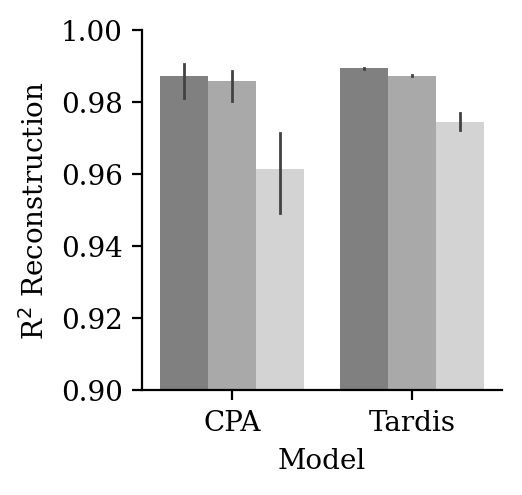

In [46]:
df_melted_ = df_melted[df_melted["model"] != "Baseline"].copy()
# df_melted_ = df_melted

rename_dict_model_name = {
    "tardis": "Tardis", 
    "cpa": "CPA",
    "baseline": "Baseline"
}

rename_set = {
    "train": "Train", 
    "validation": "Validation",
    "ood": "OOD",
}

df_melted_["model"].replace(to_replace=rename_dict_model_name, inplace=True)
df_melted_["split"].replace(to_replace=rename_set, inplace=True)

figsize = (3, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

sns.barplot(data=df_melted_, x="model", y='r2', hue="split",  palette=["gray", "darkgray", "lightgray"], err_kws={'linewidth': 1})
sns.despine()

plt.legend().set_visible(False)

plt.ylim(0.9, 1.0)
plt.ylabel(r"R$^2$ Reconstruction")
plt.xlabel("Model")

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", "fig7_afriat_r2_ood.pdf"), format="pdf")